<a href="https://colab.research.google.com/github/tuyishimejohnson/sound-clustering/blob/main/Johnson_Tuyishime_sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [69]:
#Make allNecessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import librosa
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds"

# List files in the directory
audio_files = os.listdir(unlabelled_data_path)

print(f"Total files: {len(audio_files)}")
print(f"Sample files: {audio_files[:5]}")

Total files: 80
Sample files: ['10.wav', '104.wav', '103.wav', '1054.wav', '1038.wav']


In [72]:
#Extract Features
features = []
for audio_file in audio_files:
    audio_path = os.path.join(unlabelled_data_path, audio_file)
    audio, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs.T, axis=0))

# Convert features to NumPy array for visualization
feature_array = np.array(features)


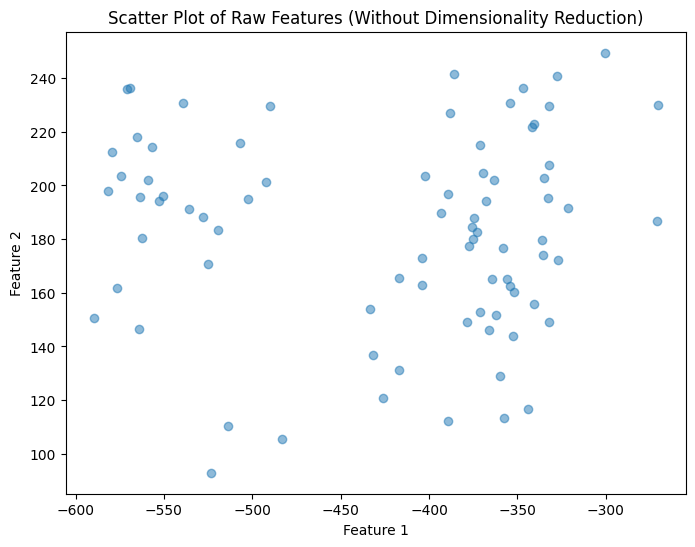

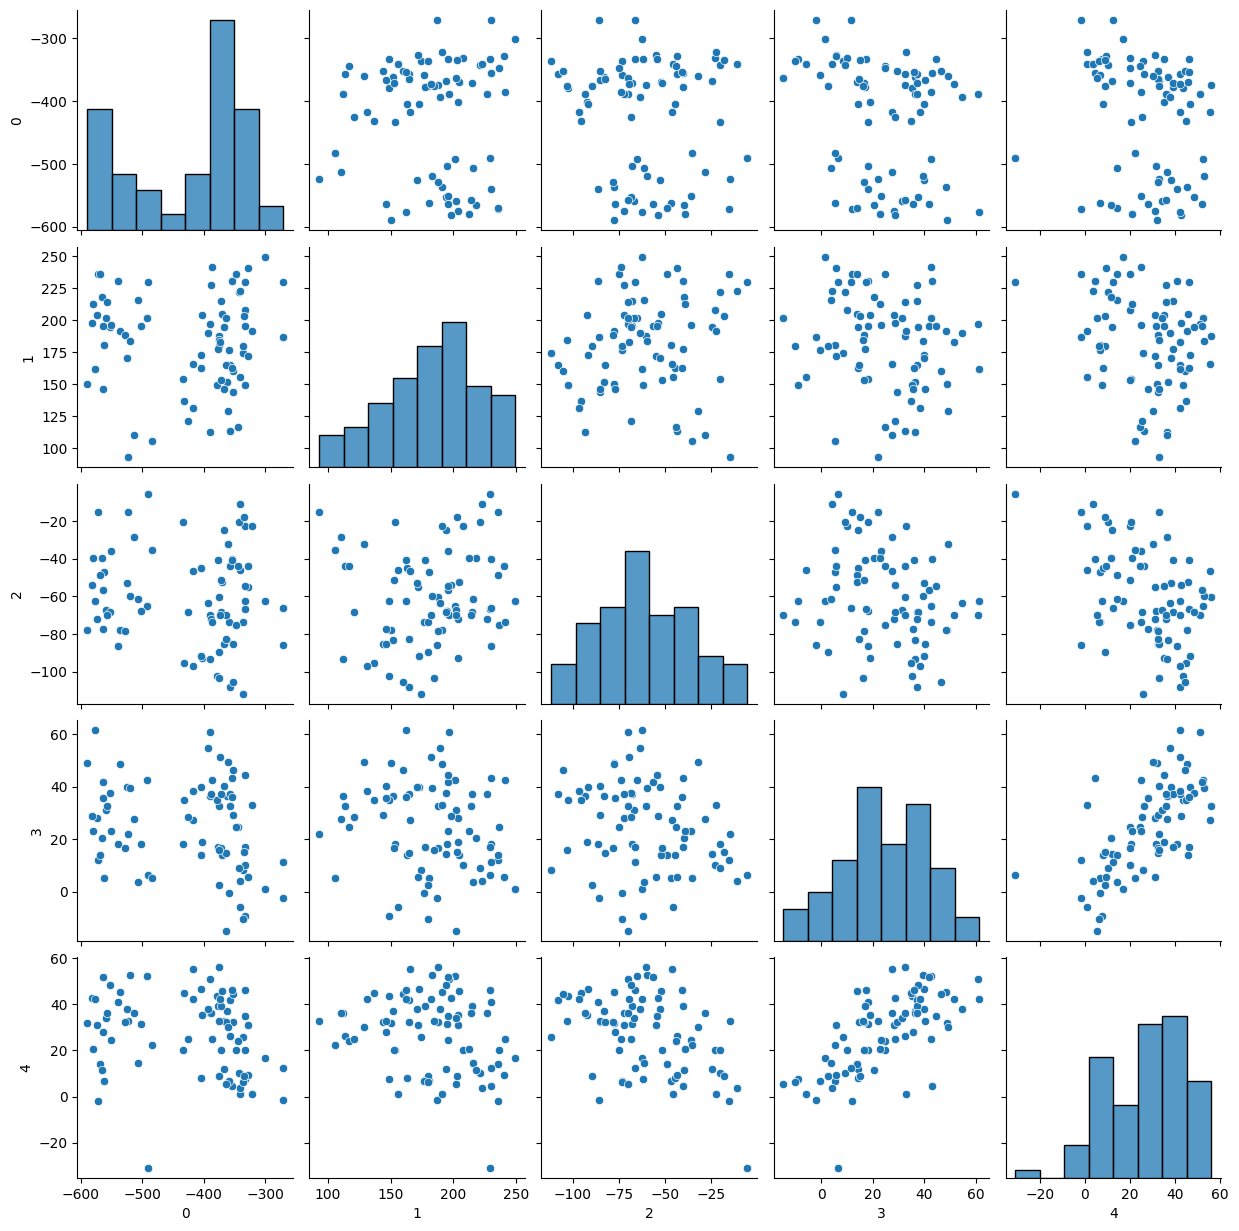

In [73]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(feature_array[:, 0], feature_array[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(feature_array[:, :5])
sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

- It helped in improving computational efficiency by reducing the number of features to process data faster.

- It also helped in identifying the most important features in a dataset to assist in understanding the relationships between variables.

- Reduces storage requirements by compressing data.




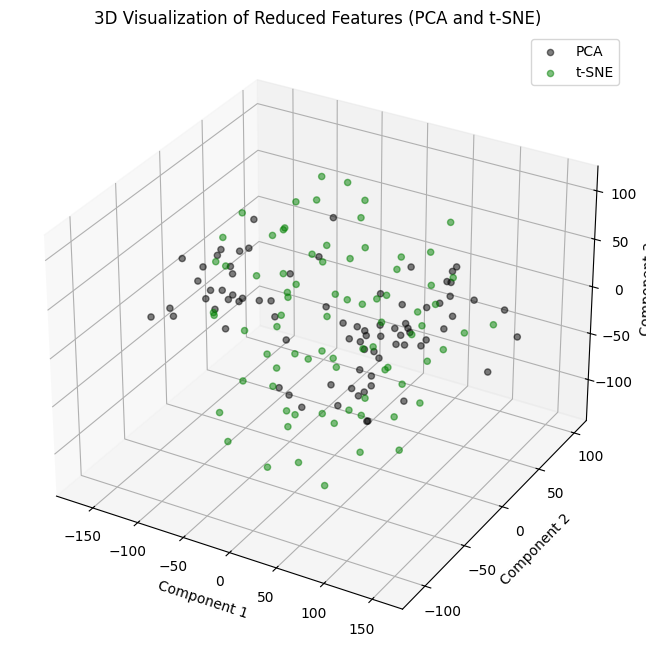

In [74]:
# Apply PCA (3 components)

pca = PCA(n_components=3)
features_pca = pca.fit_transform(feature_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(feature_array)

# 3D Visualization goes here

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# PCA Visualization
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
           c='black', label='PCA', alpha=0.5)


# t-SNE Visualization
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2],
           c='green', label='t-SNE', alpha=0.5)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.title('3D Visualization of Reduced Features (PCA and t-SNE)')
plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

- t-SNE prioritizes local structure, which means it tries to keep similar points closer together.
- t-SNE captures nonlinear relationships and highlights clusters.

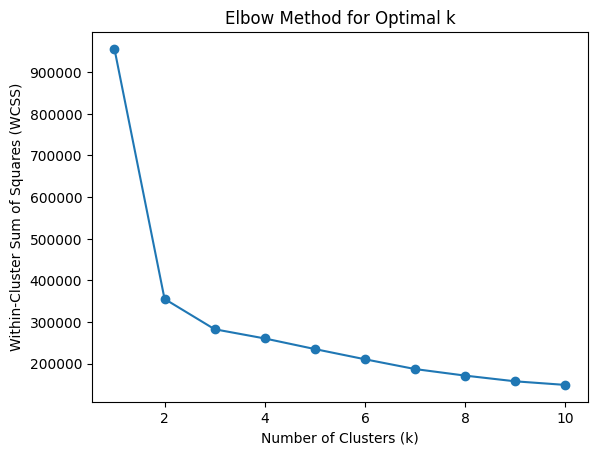

In [75]:

# Optimize number of clusters using Elbow Method
wcss = []
# kmeans = KMeans(None)

# Try k values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans with k clusters
    kmeans.fit(feature_array) # fit to the data
    wcss.append(kmeans.inertia_)  # Append WCSS to the list

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


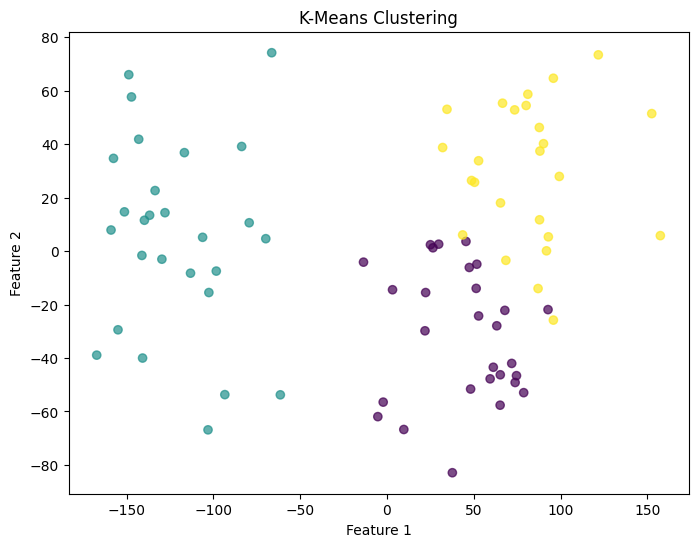

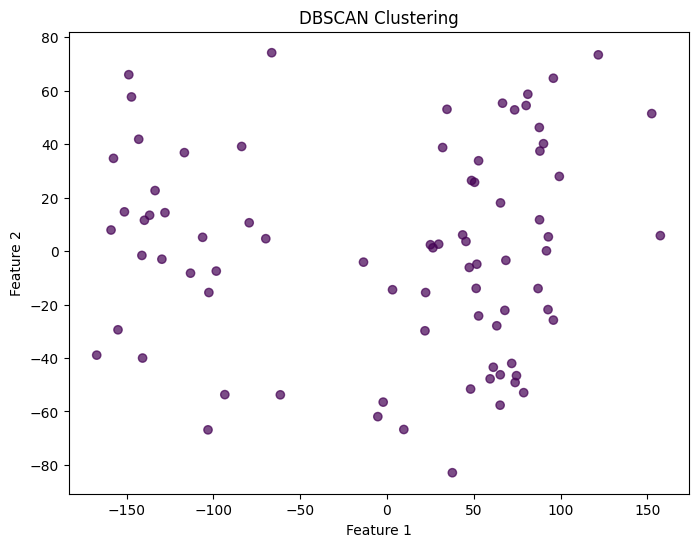

In [76]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [77]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate clustering

kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.4004, Davies-Bouldin Index: 1.0001
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

- K-Means performed better than DBSCAN by achieving higher Silhouette Scores and lower Davies-Bouldin Indices.
- DBSCAN might have struggled due to data characteristics or parameter settings.
- Dimensionality reduction likely aided both methods by highlighting key features.

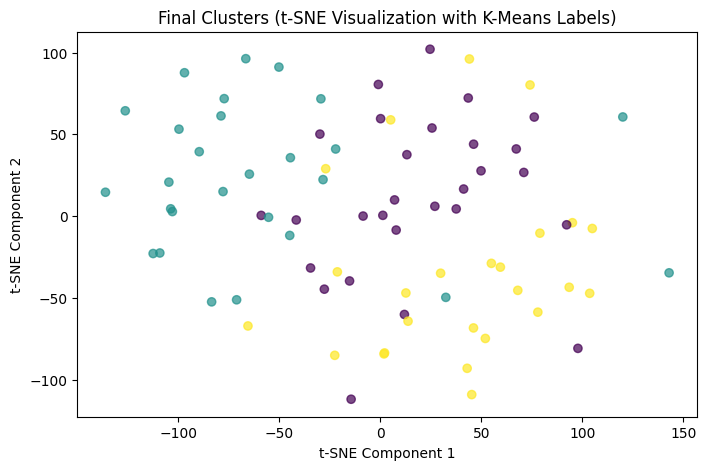

In [78]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
### Explain why dimensionality reduction helped (or didn't) in clustering.
It helped in reducing noise, highlighted key features and improved separation of clusters.
### Justify why certain clustering methods worked better.

K-Means worked better with the structure of the datased while DBSCAN struggled with density or parameters.


### Relate findings to real-world clustering challenges.


Selecting an algorithm to use is important as it helps in analyzing data characteristics and impact the performance as it can be used in various tasks such as NLP, image recognition or image compression.